### Part A — Data Engineering & Pipeline 
Check the encodings for file advanced_case_study_data.csv

In [1]:
import chardet
with open(r'F:\PLG_case_study\data\raw\advanced_case_study_data.csv', 'rb') as f:
    data = f.read(200000)
result = chardet.detect(data)
print(result)

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


Load the data

In [2]:
import pandas as pd
df = pd.read_csv(r'F:\PLG_case_study\data\raw\advanced_case_study_data.csv', encoding='utf-8')
print(df.head())

          customer_id     subscription_id legacy_system_id subscription_date  \
0  b7a782741f667201b5  ee8f208b135d4940db          SYS_NEW        2010-09-18   
1  b7a782741f667201b5  7db88cdd3c295d2276          SYS_OLD        14-05-2020   
2  d89f3a35931c386956  5c74d3dd8616593a3f          SYS_NEW          02/07/12   
3  d89f3a35931c386956  797e5af4abd9f8d8e0          SYS_NEW        2021-08-10   
4  9103c8c82514f39d83  a210495a82b1a68acb          SYS_NEW        2014-10-18   

  participant_age marketing_channel country_code postcode_area  \
0              53       Online paid           DE         28289   
1              53               NaN           DE         28289   
2              88                DM           NO     NO-111 97   
3              88       Online paid           NO     NO-111 97   
4              87                DM           NO     NO-195 40   

   extra_draws_per_year add_ons  ...  \
0                     1     0,0  ...   
1                     2       1  ...   
2 

Some columns (features) contain a mix of uppercase and lowercase letters; convert them all to lowercase

In [3]:
columns=df.columns
for i in columns:
    try:
        df[i]=df[i].str.lower()
    except:
        pass

Remove missing values
Replace ['unknown','missing'] with np.nan. First, check the proposition of missing value of each feature, and drop any features whose proportion of missing values exceeds a specified threshold (e.g., 0.2). Second, drop samples that contain at least one missing value.

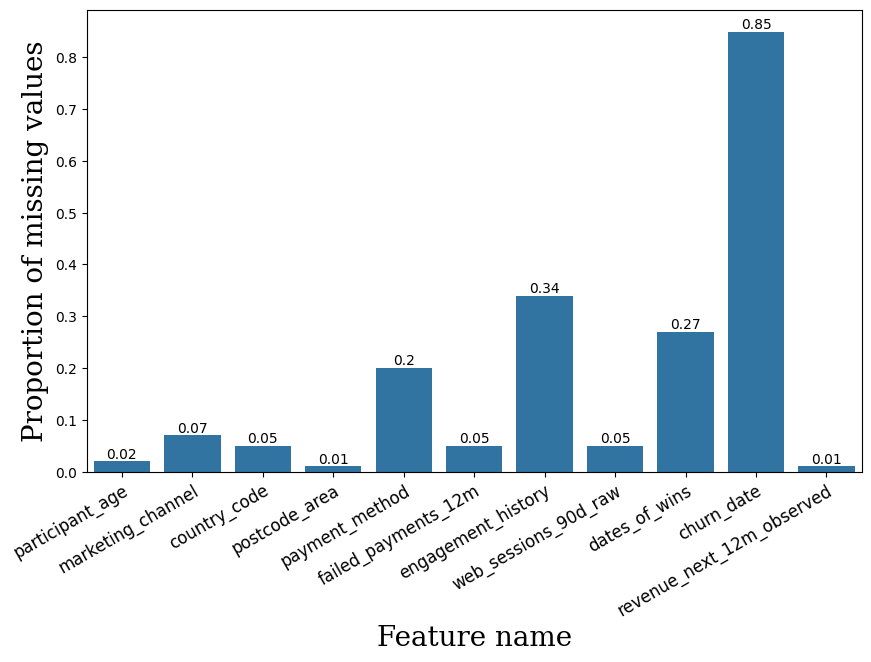

Proportion of samples that contain at least one missing value.: 22.52%


In [4]:
import numpy as np
df.replace(['unknown','missing'], np.nan, inplace=True)
#check the missing value for each feature
missing_count=df.isna().sum()
missing_count=round(missing_count[missing_count!=0]/df.shape[0],2)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
ax=sns.barplot(missing_count)
plt.xticks(rotation=30,ha='right', rotation_mode='anchor',fontsize=12)
plt.xlabel("Feature name",fontdict= {'family':'serif','size':20})
plt.ylabel("Proportion of missing values",fontdict= {'family':'serif','size':20})
for container in ax.containers:
    ax.bar_label(container)
plt.show()

#drop any features whose proportion of missing values exceeds a specified threshold (e.g., 0.2)
missing_count.sort_values(inplace=True,ascending=False)
missing_count=missing_count[missing_count>=0.2]
feature_remove=list(missing_count.index)
df1=df.drop(columns=feature_remove)

val1=df1.isnull().values.any(axis=1).sum()/df1.shape[0]
print(f"Proportion of samples that contain at least one missing value.: {round(100*val1,2)}%")
df1=df1.dropna()##remove samples that contain at least one missing value

From the plot, we can see that features such as churn_date and engagement_history contain a high proportion of missing values. It’s better to drop these features before removing samples with missing values; otherwise, a large number of customer records would be eliminated.

Handle date formats: convert different date formats to a given date format ('%Y-%m-%d')

In [5]:
df1['subscription_date'].head(5)

0    2010-09-18
2      02/07/12
3    2021-08-10
4    2014-10-18
7    28-04-2020
Name: subscription_date, dtype: object

In [6]:
import dateutil.parser
df2=df1.copy()
df2['subscription_date']=df2['subscription_date'].apply(lambda x: dateutil.parser.parse(x).strftime("%Y-%m-%d"))
df2['observation_end_date']=df2['observation_end_date'].apply(lambda x: dateutil.parser.parse(x).strftime("%Y-%m-%d"))
print(df2['subscription_date'].head(5))

0    2010-09-18
2    2012-02-07
3    2021-08-10
4    2014-10-18
7    2020-04-28
Name: subscription_date, dtype: object


All dates have been converted to a consistent '%Y-%m-%d' format.
BUt these two date formats may not be usable directly, so a new feature (subscription_month_length) is created to make use of this information

In [7]:
o1=df2['subscription_date']+','+df2['observation_end_date']
from datetime import datetime
def month_difference(date_str):
    a=date_str.split(',')
    d1 = datetime.strptime(a[1], '%Y-%m-%d')
    d2 = datetime.strptime(a[0], '%Y-%m-%d')
    return d1.month - d2.month + 12*(d1.year - d2.year)
df2['subscription_month_length']=o1.apply(lambda x: month_difference(x))
print(df2.columns)

Index(['customer_id', 'subscription_id', 'legacy_system_id',
       'subscription_date', 'participant_age', 'marketing_channel',
       'country_code', 'postcode_area', 'extra_draws_per_year', 'add_ons',
       'failed_payments_12m', 'monthly_spend_estimated',
       'donation_share_charity', 'web_sessions_90d_raw',
       'service_contacts_12m', 'complaints_12m', 'lifetime_wins',
       'campaign_cohort', 'treatment_sent_flag', 'offer_cost_eur',
       'baseline_churn_risk_band', 'historic_revenue_12m', 'churned',
       'observation_end_date', 'revenue_next_12m_observed',
       'subscription_month_length'],
      dtype='object')


Replace "," with "." for feature "add_ons".

In [8]:
df2['add_ons']=df2['add_ons'].apply(lambda x: int(float((x.replace(',','.')))))

The features monthly_spend_estimated, offer_cost_eur, historic_revenue_12m, and revenue_next_12m_observed contain mixed currency units, so we need to convert all values to euros.

In [9]:
df2[['monthly_spend_estimated','offer_cost_eur','historic_revenue_12m','revenue_next_12m_observed']].head(5)

,monthly_spend_estimated,offer_cost_eur,historic_revenue_12m,revenue_next_12m_observed
0,$13.67,0,$201.11,$154.32
2,$15.14,$23.17,$226.13,$198.58
3,$15.79,$19.88,$186.94,$216.82
4,$17.74,$13.51,$265.82,$180.29
7,"€21,64","€15,78","€212,35","€220,69"


In [10]:
from currency_converter import CurrencyConverter
c = CurrencyConverter()
def Currency_Conversion(x:str) ->float:
    x=x.replace(',','.')
    if x.startswith("$"):  
        return round(c.convert(float(x[1:]), 'EUR', 'USD'),2)
    elif x.startswith("€"):
        return float(x[1:])
    else:
        return float(x)
for variable in ['monthly_spend_estimated','offer_cost_eur','historic_revenue_12m','revenue_next_12m_observed']:
    df2[variable]=df2[variable].apply(lambda x: Currency_Conversion(x))

In [11]:
df2[['monthly_spend_estimated','offer_cost_eur','historic_revenue_12m','revenue_next_12m_observed']].head(5)

,monthly_spend_estimated,offer_cost_eur,historic_revenue_12m,revenue_next_12m_observed
0,15.74,0.00,231.56,177.68
2,17.43,26.68,260.37,228.65
3,18.18,22.89,215.24,249.65
4,20.43,15.56,306.07,207.59
7,21.64,15.78,212.35,220.69


transform the two formats into a single one for the donation_share_charity feature

In [12]:
print(f"The raw donation_share_charity data: {df2['donation_share_charity'].head(5)}")

def handel_donation_share_charity(x:str) ->float:
    x=x.replace(',','.')
    if float(x)<1:  
        return round(float(x)*100,2)
    else:
        return round(float(x),2)
df2['donation_share_charity']=df2['donation_share_charity'].apply(lambda x: handel_donation_share_charity(x))
print(f"The preprocessed donation_share_charity data: {df2['donation_share_charity'].head(5)}")

The raw donation_share_charity data: 0    0,65
2    0,55
3    0.39
4    69,8
7    44,0
Name: donation_share_charity, dtype: object
The preprocessed donation_share_charity data: 0    65.0
2    55.0
3    39.0
4    69.8
7    44.0
Name: donation_share_charity, dtype: float64


In [13]:
##For other columns
#remove the '+' from the web_sessions_90d_raw feature; to be honest, I don't fully understand what the '+' indicates
df2['web_sessions_90d_raw']=df2['web_sessions_90d_raw'].apply(lambda x: x.strip('+'))

##'service_contacts_12m' column contains 366 outlier, these samples corresponding to these outliers need to be removed
from scipy import stats
df2=df2[(np.abs(stats.zscore(df2['service_contacts_12m'])) < 3)]
df2['treatment_sent_flag']=df2['treatment_sent_flag'].map({'true': 1, 'y': 1,'yes':1,'1':1, 'false': 0, 'n': 0,'no':0,'0':0})
print(f"The unique value for baseline_churn_risk_band: {df2['baseline_churn_risk_band'].unique()}")
df2['baseline_churn_risk_band']=df2['baseline_churn_risk_band'].str.replace("_",' ')
df2['churned']=df2['churned'].map({'true': 1, 'y': 1,'yes':1,'1':1, 'false': 0, 'n': 0,'no':0,'0':0})
#check the type for each column
columns=list(df2.columns)
di={}
for i in columns:
    di[i]=df2[i].dtype
print(f"The data type for each column: {di}")


col1=['participant_age','web_sessions_90d_raw']
for variable in col1:
    df2[variable]=df2[variable].apply(lambda x: int(x))

The unique value for baseline_churn_risk_band: ['low' 'very high' 'medium' 'high' 'very_high']
The data type for each column: {'customer_id': dtype('O'), 'subscription_id': dtype('O'), 'legacy_system_id': dtype('O'), 'subscription_date': dtype('O'), 'participant_age': dtype('O'), 'marketing_channel': dtype('O'), 'country_code': dtype('O'), 'postcode_area': dtype('O'), 'extra_draws_per_year': dtype('int64'), 'add_ons': dtype('int64'), 'failed_payments_12m': dtype('float64'), 'monthly_spend_estimated': dtype('float64'), 'donation_share_charity': dtype('float64'), 'web_sessions_90d_raw': dtype('O'), 'service_contacts_12m': dtype('int64'), 'complaints_12m': dtype('int64'), 'lifetime_wins': dtype('int64'), 'campaign_cohort': dtype('O'), 'treatment_sent_flag': dtype('int64'), 'offer_cost_eur': dtype('float64'), 'baseline_churn_risk_band': dtype('O'), 'historic_revenue_12m': dtype('float64'), 'churned': dtype('int64'), 'observation_end_date': dtype('O'), 'revenue_next_12m_observed': dtype('fl

Only consider 3 situations: 
    'campaign_cohort'='Control' and 'treatment_sent_flag'=0;
    'campaign_cohort'='Variant_A' and 'treatment_sent_flag'=1;
    'campaign_cohort'='Variant_B' and 'treatment_sent_flag'=1;

In [14]:
df2=df2.loc[((df2['campaign_cohort']=='control') & (df2['treatment_sent_flag']==0))|
           ((df2['campaign_cohort']=='variant_a') & (df2['treatment_sent_flag']==1))|
           ((df2['campaign_cohort']=='variant_b') & (df2['treatment_sent_flag']==1))]
df2.drop(columns=['legacy_system_id','subscription_date','postcode_area','observation_end_date'],inplace=True)

Examine the distribution of features with numeric values

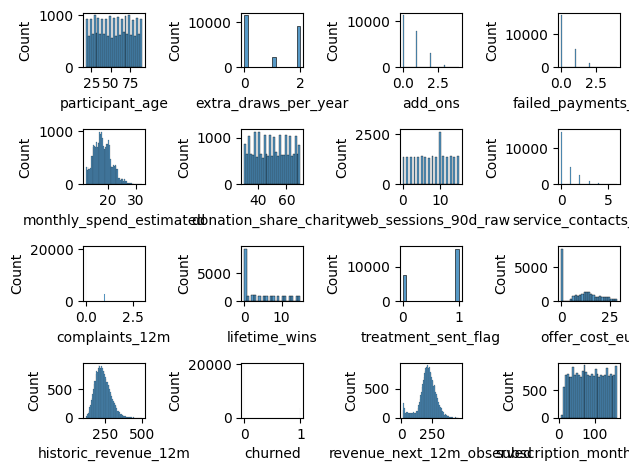

In [15]:
col0=['participant_age','extra_draws_per_year',
 'add_ons','failed_payments_12m',
 'monthly_spend_estimated','donation_share_charity',
 'web_sessions_90d_raw','service_contacts_12m',
 'complaints_12m','lifetime_wins',
 'treatment_sent_flag','offer_cost_eur',
 'historic_revenue_12m','churned',
 'revenue_next_12m_observed','subscription_month_length']
fig, axes = plt.subplots(4, 4)
axes = axes.ravel()
for col,ax in  zip(list(df2[col0].columns),axes):
        sns.histplot(df2[col],ax=ax) 
plt.tight_layout() 
plt.show()   

In [16]:
##Save the cleaned data
df2.to_csv(r'F:\PLG\data\processed\retention_model_data.csv',index=False)  

## Part B — Predictive Modeling 

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import pickle

df=pd.read_csv(r'F:\PLG\data\processed\retention_model_data.csv')

In [18]:
df.head()

,customer_id,subscription_id,participant_age,marketing_channel,country_code,extra_draws_per_year,add_ons,failed_payments_12m,monthly_spend_estimated,donation_share_charity,...,complaints_12m,lifetime_wins,campaign_cohort,treatment_sent_flag,offer_cost_eur,baseline_churn_risk_band,historic_revenue_12m,churned,revenue_next_12m_observed,subscription_month_length
0,b7a782741f667201b5,ee8f208b135d4940db,53,online paid,de,1,0,0.0,15.74,65.0,...,0,14,control,0,0.00,low,231.56,0,177.68,153
1,d89f3a35931c386956,5c74d3dd8616593a3f,88,dm,no,2,1,0.0,17.43,55.0,...,0,13,variant_b,1,26.68,very high,260.37,0,228.65,136
2,d89f3a35931c386956,797e5af4abd9f8d8e0,88,online paid,no,0,0,0.0,18.18,39.0,...,0,11,variant_b,1,22.89,medium,215.24,0,249.65,22
3,9103c8c82514f39d83,a210495a82b1a68acb,87,dm,no,2,0,2.0,20.43,69.8,...,0,0,variant_a,1,15.56,low,306.07,1,207.59,104
4,6eb887126d24e8f1cd,cbd52a6ef80d39c008,31,tv,de,0,2,0.0,21.64,44.0,...,1,9,variant_b,1,15.78,medium,212.35,0,220.69,38


Remove features that are not useful to train ML models

In [19]:
df.drop(columns=['customer_id','subscription_id','campaign_cohort','treatment_sent_flag','revenue_next_12m_observed'],inplace=True)

Performing encoding on categorical variables.

In [20]:
#label encodling for ordinal data
df['baseline_churn_risk_band']=df['baseline_churn_risk_band'].map({'low':0,'medium':1,'high':2,'very high':3})

##One hot encoding for nominal data
df1 = pd.get_dummies(data=df, columns=['marketing_channel','country_code'],dtype=float, drop_first=True)
X = df1.drop('churned',axis='columns').values
y = df1['churned'].values

Split training and test set

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1/5), random_state=1, stratify=y)

Handle imbalanced data by oversampling

In [22]:
print(f"The proportion for each class before oversampling: ({(y_train==1).sum()/len(y_train)}, {(y_train==0).sum()/len(y_train)})")
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)
print(f"The proportion for each class after oversampling: ({(y_train==1).sum()/len(y_train)}, {(y_train==0).sum()/len(y_train)})")

The proportion for each class before oversampling: (0.1496787542197539, 0.8503212457802461)
The proportion for each class after oversampling: (0.5, 0.5)


Perform feature standardization.

In [23]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Building 4 models for classification: K-Nearest Neighbors (KNN), Logistic Regression (LR), Random Forest (RF) and Gradient Boosting (GBoost)

In [24]:
def all_eval_metrics(y_test,y_pred_prob):
    acc=[]
    acc.append(roc_auc_score(y_test, y_pred_prob))
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    acc.append(auc(recall,precision))
    return acc

def KNN_my(X_train, X_test, y_train, y_test):
    param_grid={'n_neighbors': np.arange(2, 10, 2)}
    knn=KNeighborsClassifier()
    grid = GridSearchCV(knn, param_grid, refit = True, verbose = 3)##the default 5-fold cross validation
    grid.fit(X_train, y_train) ## fitting the model for grid search 
    y_pred_prob = grid.predict_proba(X_test)[:, 1]
    ac=all_eval_metrics(y_test,y_pred_prob)
    return ac,grid

def LogisticRegression_my(X_train, X_test, y_train, y_test):
    param_grid = {   'C': [1,0.1,0.01,0.001,0.0001]}   
    grid = GridSearchCV(LogisticRegression(random_state=0), param_grid, refit = True, verbose = 3)##the default 5-fold cross validation
    grid.fit(X_train, y_train) ## fitting the model for grid search 
    y_pred_prob = grid.predict_proba(X_test)[:, 1]
    ac=all_eval_metrics(y_test,y_pred_prob)
    return ac,grid

def RandomForestClassifier_my(X_train, X_test, y_train, y_test):
    param_grid= { 'n_estimators': [100,200]} #many parameters have been tested
    grid= GridSearchCV(RandomForestClassifier(random_state=1), param_grid,refit = True, verbose = 3)
    grid.fit(X_train, y_train)
    y_pred_prob = grid.predict_proba(X_test)[:, 1]
    ac=all_eval_metrics(y_test,y_pred_prob)
    return ac,grid

def GradientBoostingClassifier_my(X_train, X_test, y_train, y_test):
    param_grid = {'n_estimators': [100,200]}  
    grid = GridSearchCV(GradientBoostingClassifier(random_state=0), param_grid, refit = True, verbose = 3)##the default 5-fold cross validation
    grid.fit(X_train, y_train) 
    y_pred_prob = grid.predict_proba(X_test)[:, 1]
    ac=all_eval_metrics(y_test,y_pred_prob)
    return ac,grid

Train the models (this can take a few minites)

In [ ]:
ac1,knn_model=KNN_my(X_train, X_test, y_train, y_test)
ac2,LR_model=LogisticRegression_my(X_train, X_test, y_train, y_test)
ac3,RF_model=RandomForestClassifier_my(X_train, X_test, y_train, y_test)
ac4,GBoost_model=GradientBoostingClassifier_my(X_train, X_test, y_train, y_test)

Save the models and also the prediction evaluation 

In [32]:
def save_model(model, file_path: str) -> None:
    """Save the trained model to a file."""
    with open(file_path, 'wb') as file:
            pickle.dump(model, file)

save_model(knn_model, 'F:\PLG\data\outputs\knn_model.pkl')
save_model(LR_model, 'F:\PLG\data\outputs\LR_model.pkl')
save_model(RF_model, 'F:\PLG\data\outputs\RF_model.pkl')
save_model(GBoost_model, 'F:\PLG\data\outputs\GBoost_model.pkl')

prediction_acc=pd.DataFrame({'K-Nearest Neighbors':ac1,'Logistic Regression':ac2,'Random Forest':ac3,'Gradient Boosting':ac4},index=['ROC AUC','PR AUC'])
for col in prediction_acc.columns:
    prediction_acc[col]=prediction_acc[col].apply(lambda x: round(x,4))
print(f"Prediction evaluation is: {prediction_acc}")
prediction_acc.to_csv(r'F:\PLG\data\outputs\prediction_acc.csv')


Prediction evaluation is:          K-Nearest Neighbors  Logistic Regression  Random Forest  \
ROC AUC               0.5900               0.7865         0.8227   
PR AUC                0.2992               0.4031         0.4367   

         Gradient Boosting  
ROC AUC             0.8267  
PR AUC              0.4576  


Explore the feature importance

The correlation between RF and GBoost in terms of feature importance:
                RandomForest  GradientBoost
RandomForest       1.000000       0.718085
GradientBoost      0.718085       1.000000


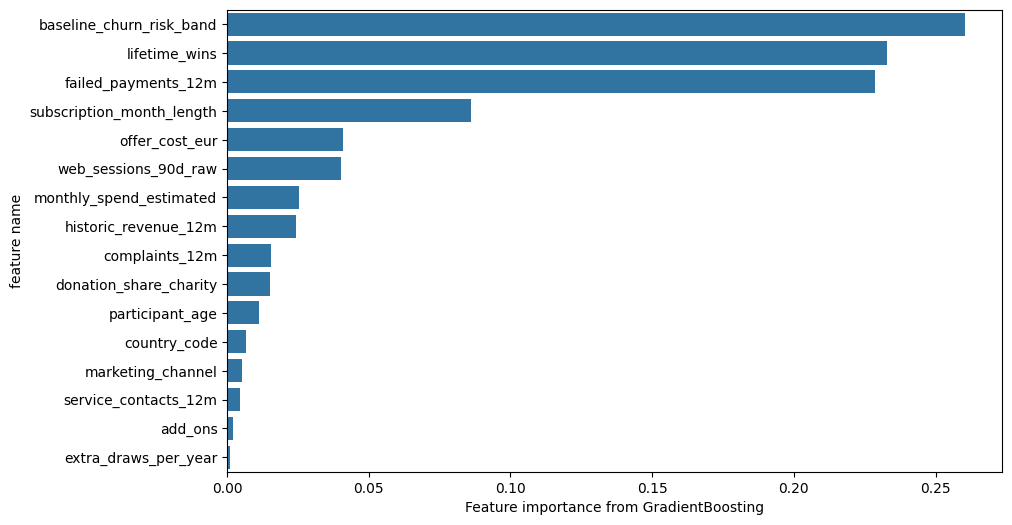

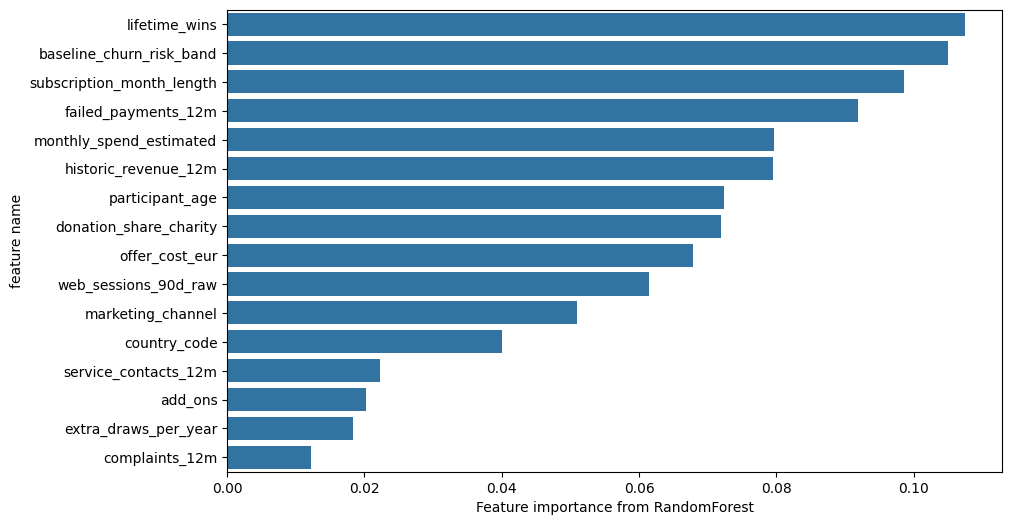

In [36]:
feature_importance1=RF_model.best_estimator_.feature_importances_
feature_importance2=GBoost_model.best_estimator_.feature_importances_

g1=list(df1.drop('churned',axis='columns').columns)
g1=g1[:14]+['marketing_channel','country_code']

p1=feature_importance1[:14]
p1=np.append(p1,[sum(feature_importance1[14:20]),sum(feature_importance1[20:])])

p2=feature_importance2[:14]
p2=np.append(p2,[sum(feature_importance2[14:20]),sum(feature_importance2[20:])])

o1=pd.DataFrame({'features':g1,'RandomForest':p1,'GradientBoost':p2})

print(f"The correlation between RF and GBoost in terms of feature importance:\n {o1.drop('features',axis='columns').corr()}")        
o1.sort_values(by=['GradientBoost'],inplace=True,ascending=False)
o1.to_csv(r'F:\PLG\data\outputs\feature_importance.csv')

#Feature importance from Gradient Boosting
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.barplot(o1,y='features',x='GradientBoost')
plt.ylabel("feature name")
plt.xlabel('Feature importance from GradientBoosting')
plt.show()

#Feature importance from Random Forest
o1.sort_values(by=['RandomForest'],inplace=True,ascending=False)
#o1.to_csv(r'F:\PLG\data\model_save\feature_importance.csv')
plt.figure(figsize=(10, 6))
sns.barplot(o1,y='features',x='RandomForest')
plt.ylabel("feature name")
plt.xlabel('Feature importance from RandomForest')
plt.show()

From the plots, we can see that lifetime_wins, baseline_churn_risk_band, failed_payments_12m, and subscription_month_length are very important features for determining whether a customer will churn.

Customer Value / LTV Approximation

Lifetime Value=(Average Yearly Revenue per User) × (Gross Margin %) × (Expected Lifetime in Years)

In [38]:
import pandas as pd
df=pd.read_csv(r'F:\PLG\data\processed\retention_model_data.csv')

## Lifetime Value=(Average Yearly Revenue per User) × (Gross Margin %) × (Expected Lifetime in Years)
churn_rate=(df['churned']==1).sum()/len(df)
revenue_per_user=df['monthly_spend_estimated']*12*(1-0.01*df['donation_share_charity'])#-df['offer_cost_eur']
average_revenue_per_user=revenue_per_user.mean()

LTV_past_year=(average_revenue_per_user/churn_rate).item()
LTV_next_year=((df['revenue_next_12m_observed'].mean())/churn_rate).item()
LTV_mean=(LTV_past_year+LTV_next_year)/2

LTV=pd.DataFrame({'LTV':[round(LTV_past_year,2),round(LTV_next_year,2),round(LTV_mean,2)]},
                index=['LTV_past_year','LTV_next_year','LTV_mean'])
 
LTV.to_csv(r'F:\PLG\data\outputs\LTV.csv')


## Part C — Causal & Uplift Analysis 

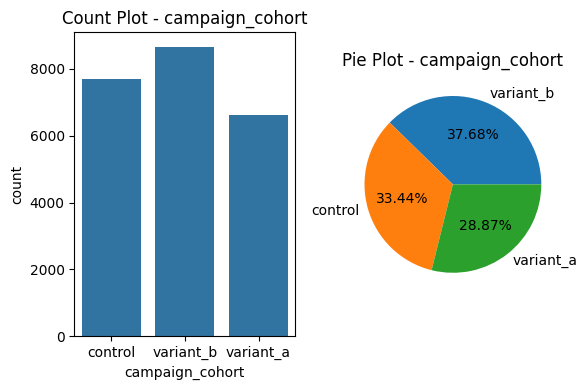

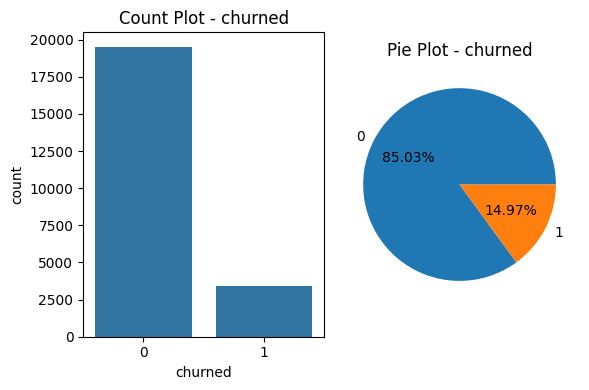

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv(r'F:\PLG\data\processed\retention_model_data.csv')
def plot_count_pie(df,variable):
    plt.figure(figsize=(6,4))
    plt.subplot(1,2,1)
    sns.countplot(x=variable,data=df)
    plt.title(f'Count Plot - {variable}')
    plt.subplot(1,2,2)
    counts=df[variable].value_counts()
    plt.pie(counts,labels=counts.index,autopct='%0.2f%%')
    plt.title(f'Pie Plot - {variable}')
    plt.tight_layout()
    plt.show()
plot_count_pie(df,variable='campaign_cohort')
plot_count_pie(df,variable='churned')

A two-proportions z-test will be used. It's a statistical hypothesis test that determines if there's a significant difference between the proportions (percentages) of a binary outcome (yes/no, success/fail) in two independent groups.

In [41]:
def two_proportion_z_test(df1, variable,alpha):
    df1_A=df1.loc[(df1['campaign_cohort']=='control') | (df1['campaign_cohort']==variable)]

    N_con=(df1_A["campaign_cohort"] == "control").sum().item()
    N_exp =(df1_A["campaign_cohort"] == variable).sum().item()
    
    # calculating the total number of churn per group by summing 1's
    X_con = df1_A.groupby("campaign_cohort")["churned"].sum().loc["control"].item()
    X_exp =df1_A.groupby("campaign_cohort")["churned"].sum().loc[variable].item()
    
    # computing the estimate of churn probability per group
    p_con_hat = X_con/N_con
    p_exp_hat = X_exp/N_exp
    
    # computing the estimate of pooled churned probability
    p_pooled_hat = (X_con+X_exp)/(N_con + N_exp)
    # computing the estimate of pooled variance
    pooled_variance = p_pooled_hat * (1-p_pooled_hat) * (1/N_con + 1/N_exp)
    # computing the standard error of the test
    SE = np.sqrt(pooled_variance)
    
    # computing the test statistics of Z-test
    Test_stat = round((p_exp_hat - p_con_hat)/SE,3)
    #ATE estimation (difference in means)
    ATE=round((p_exp_hat - p_con_hat) ,3)
    # critical value of the Z-test
    Z_crit = round(norm.ppf(1-alpha/2),3)
    #calculating p value
    p_value = round(2 * norm.sf(abs(Test_stat)).item(),3)#sf--survival function 
    # Calculate the Confidence Interval (CI) for a 2-sample Z-test
    ## Calculate the lower and upper bounds of the confidence interval
    CI = [round((p_exp_hat - p_con_hat) - SE*Z_crit, 3).item(),  
        round((p_exp_hat - p_con_hat) + SE*Z_crit, 3) .item()  ]
    return [ATE, CI, p_value, Test_stat]

Apply two-proportions z-test to our data to see variant_a/variant_b has an impact to the churned rate.

In [43]:
ATE_a=two_proportion_z_test(df, variable='variant_a',alpha=0.05)
ATE_b=two_proportion_z_test(df, variable='variant_b',alpha=0.05)

In [54]:
def print_fun(ATE_a, variable):
    print(f"The point estimate for average treatment effect on churn for {variable} vs Control:\n {ATE_a[0]}")
    print(f"The confidence interval for average treatment effect on churn for {variable} vs Control:\n {ATE_a[1]}")
    alpha=0.05
    if ATE_a[2] <alpha:
        print(f"The p-value is {ATE_a[2]}, so the difference between Control and Experimental group ({variable}) is significant.")
    else:
        print(f"The p-value is {ATE_a[2]}, so the difference between Control and Experimental group ({variable}) is not significant.")
print_fun(ATE_a, 'variant_a')
print('\n')
print_fun(ATE_b, 'variant_b')

The point estimate for average treatment effect on churn for variant_a vs Control:
 -0.024
The confidence interval for average treatment effect on churn for variant_a vs Control:
 [-0.035, -0.012]
The p-value is 0.0, so the difference between Control and Experimental group (variant_a) is significant.


The point estimate for average treatment effect on churn for variant_b vs Control:
 -0.001
The confidence interval for average treatment effect on churn for variant_b vs Control:
 [-0.012, 0.01]
The p-value is 0.893, so the difference between Control and Experimental group (variant_b) is not significant.


Treatment Effect Heterogeneity (Segments)

participant_age and baseline_churn_risk_band are used separately to group customers, and a z-test is then applied within each group.

In [55]:
df_age_low=df.loc[df['participant_age']<=50]
df_age_high=df.loc[df['participant_age']>50]
ATE_a_age_low=two_proportion_z_test(df_age_low, variable='variant_a', alpha=0.05)
ATE_a_age_high=two_proportion_z_test(df_age_high, variable='variant_a', alpha=0.05)

ATE_b_age_low=two_proportion_z_test(df_age_low, variable='variant_b', alpha=0.05)
ATE_b_age_high=two_proportion_z_test(df_age_high, variable='variant_b', alpha=0.05)

d1=pd.DataFrame({'variant_a':ATE_a,'variant_b':ATE_b,
                            'Age<=50 (variant_a)':ATE_a_age_low, 'Age>50 (variant_a)':ATE_a_age_high,
                            'Age<=50 (variant_b)':ATE_b_age_low, 'Age>50 (variant_b)':ATE_b_age_high},
                            index=['ATE', 'confidence_intervals', 'p_value','Test_stat'])

d2={}
col1=list(df['baseline_churn_risk_band'].unique())
for i in col1:
    df_seg=df.loc[df['baseline_churn_risk_band']==i]
    ATE_seg_a=two_proportion_z_test(df_seg, variable='variant_a', alpha=0.05)
    ATE_seg_b=two_proportion_z_test(df_age_high, variable='variant_b', alpha=0.05)
    d2[i+' (variant_a)']=ATE_seg_a
    d2[i+' (variant_b)']=ATE_seg_b
d2=pd.DataFrame(d2,index=['ATE', 'confidence_intervals', 'p_value','Test_stat'])

AB_test_result=pd.merge(d1,d2,left_index=True, right_index=True)

In [57]:
print(f"All the AB testing results:\n {AB_test_result.T}")

All the AB testing results:
                          ATE confidence_intervals p_value Test_stat
variant_a             -0.024     [-0.035, -0.012]     0.0    -4.016
variant_b             -0.001       [-0.012, 0.01]   0.893    -0.134
Age<=50 (variant_a)   -0.017        [-0.034, 0.0]   0.057    -1.907
Age>50 (variant_a)     -0.03     [-0.045, -0.014]     0.0    -3.749
Age<=50 (variant_b)   -0.001      [-0.018, 0.016]     0.9    -0.126
Age>50 (variant_b)      -0.0      [-0.015, 0.014]   0.952     -0.06
low (variant_a)       -0.023     [-0.037, -0.008]   0.002     -3.07
low (variant_b)         -0.0      [-0.015, 0.014]   0.952     -0.06
very high (variant_a) -0.027      [-0.079, 0.025]   0.308    -1.019
very high (variant_b)   -0.0      [-0.015, 0.014]   0.952     -0.06
medium (variant_a)    -0.018     [-0.035, -0.001]   0.043    -2.025
medium (variant_b)      -0.0      [-0.015, 0.014]   0.952     -0.06
high (variant_a)      -0.052     [-0.083, -0.021]   0.001    -3.317
high (variant_b)   

In [59]:
#Select the ones whose p_value is smaller than alpha (0.05)
print(f"All the AB testing results:\n {AB_test_result.T[AB_test_result.T['p_value']<0.05]}")

All the AB testing results:
                       ATE confidence_intervals p_value Test_stat
variant_a          -0.024     [-0.035, -0.012]     0.0    -4.016
Age>50 (variant_a)  -0.03     [-0.045, -0.014]     0.0    -3.749
low (variant_a)    -0.023     [-0.037, -0.008]   0.002     -3.07
medium (variant_a) -0.018     [-0.035, -0.001]   0.043    -2.025
high (variant_a)   -0.052     [-0.083, -0.021]   0.001    -3.317


Overall, the results show that experiment variant_a is effective in reducing churn. Customers aged above 50 appear to benefit more from variant_a than younger customers. However, when the legacy rule-based churn risk (baseline_churn_risk_band) is very high, variant_a no longer shows a meaningful effect.

In [60]:
AB_test_result.to_csv(r'F:\PLG\data\outputs\AB_test_result.csv')

Causal Estimation Uplift Modeling
* Build a two-model approach to  estimate individual treatment effects.

In [62]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
df=pd.read_csv(r'F:\PLG\data\processed\retention_model_data.csv')

def get_ITE(df,variable='variant_a'):
    ##Remove features that are not useful to train ML models
    df1=df.drop(columns=['customer_id','subscription_id','treatment_sent_flag','revenue_next_12m_observed'])
    #label encodling for ordinal data
    df1['baseline_churn_risk_band']=df1['baseline_churn_risk_band'].map({'low':0,'medium':1,'high':2,'very high':3})
    ##One hot encoding for nominal data
    df1 = pd.get_dummies(data=df1, columns=['marketing_channel','country_code'],dtype=float, drop_first=True)   
    
    df_exp=df1.loc[df1['campaign_cohort']==variable]
    df_con=df1.loc[df1['campaign_cohort']=='control']
    
    #for model 1
    X1 = df_exp.drop(columns=['churned','campaign_cohort']).values
    y1 = df_exp['churned'].values#.astype(np.float32)
    clf1=RandomForestClassifier(n_estimators=100,random_state=1)
    clf1.fit(X1, y1)
    
    #for model 2
    X2 = df_con.drop(columns=['churned','campaign_cohort']).values
    y2 = df_con['churned'].values#.astype(np.float32)
    clf2=RandomForestClassifier(n_estimators=100,random_state=1)
    clf2.fit(X2, y2)
    
    X_all = df1.drop(columns=['churned','campaign_cohort']).values
    y_pred_prob1 = clf1.predict_proba(X_all)[:, 1]
    y_pred_prob2 = clf2.predict_proba(X_all)[:, 1]
    #ITE=y_pred_prob1-y_pred_prob2
    return y_pred_prob1-y_pred_prob2
ITE_a=get_ITE(df,variable='variant_a')
ITE_b=get_ITE(df,variable='variant_b')
df['ITE_variant_a']=ITE_a
df['ITE_variant_b']=ITE_b

In [64]:
df[['ITE_variant_a','ITE_variant_b']].head()

,ITE_variant_a,ITE_variant_b
0,0.18,0.03
1,0.09,-0.19
2,0.07,-0.02
3,0.31,0.06
4,0.05,0.00


The smaller the IET value, the more likely a customer is to be influenced by the special treatment (Variant A or Variant B).

In [65]:
#sort the data and save it
df1=df.sort_values(by=['ITE_variant_a'],ascending=True)
df1.to_csv(r'F:\PLG\data\outputs\individual_treatment_effects.csv',index=False)

## Part D (OPTIONAL-BONUS) — Targeting Policy & ROI 

My strategy is to target the top 20% of customers (20% of N, where N is the total customer base). I prioritize using Variant A, since it is both more effective and less costly than Variant B.

First, I rank customers by ['ITE_variant_a', 'ITE_variant_b'] in ascending order. From this ranking, I select the top 20% of customers. For those selected, if a customer’s ITE_variant_a is below a chosen threshold (e.g., –0.3), the customer is targeted with Variant A. If ITE_variant_a is above the threshold, I then compare ITE_variant_a and ITE_variant_b and choose the treatment with the lower value. For example, under this rule, if ITE_variant_a > ITE_variant_b, the customer should be targeted with Variant B.

In [66]:
import pandas as pd
df=pd.read_csv(r'F:\PLG\data\outputs\individual_treatment_effects.csv')
df=df.sort_values(by=['ITE_variant_a','ITE_variant_b'],ascending=True)

N=df.shape[0]
N_target=int(N*0.2)

df1=df.iloc[:N_target,:]
df1=df1.assign(variant_a_or_b='a')
df1.loc[(df1['ITE_variant_a']>-0.3) & (df1['ITE_variant_a']>df1['ITE_variant_b']),'variant_a_or_b']='b'

In [70]:
print(f"The customer who can be targeted are:\n {df1[['customer_id', 'subscription_id','variant_a_or_b']]}")


The customer who can be targeted are:
              customer_id     subscription_id variant_a_or_b
0     ae4dba1743cc6d4412  e128b879bb9bc94f0b              a
1     bbf94d74de13fcaf24  b154af8aa983c8af7a              a
2     94845a3ed9806f1cef  3a08baa7c2e5b7a99d              a
4     da072f3478f3b06a78  2f72bed24d5e5f3ff5              a
3     75764a6c5b5f3007d5  733852019f38b3bf2e              a
...                  ...                 ...            ...
4339  b0e864a6eccfc779c8  8da69a406faf3620c2              a
4460  89c44761d7bafba48b  c067cee2af33d419d4              a
4394  f075ae724a0ea982e4  05a60bfce1943963dd              a
4616  3af3d94fb6259a153c  e04a941977eef31d44              a
4294  404e0793ba47ba6ec7  d05bc42ca52ef3a848              a

[4591 rows x 3 columns]


In [72]:
total_cost=(df1['variant_a_or_b']=='a').sum()*10+(df1['variant_a_or_b']=='b').sum()*20
print(f"An approximate for the value of saving a subscription: {total_cost/N_target}")

An approximate for the value of saving a subscription: 11.605314746242648


In [73]:
#Save the results
df1.to_csv(r'F:\PLG\data\outputs\targeting_customer.csv')